In [0]:
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# !pip install category_encoders
from category_encoders import LeaveOneOutEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [0]:
absent = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv",
    sep=";",
)
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


Find which variables have the highest pairwise correlation and remove them from our dataset. Additionally, try to think of which variables are correlated by looking at the column names and remove those columns as well.

Note: When choosing between two categorical variables that are correlated, keep the one with fewer unique categories.

Split the data into train and test with test containing 20% of the data.

In [0]:
drop_cols = [
    "Body mass index",   # Highly correlated with weight and just picked one to drop
    "Age",               # Highly correlated with LOS and prolly against law to use
    "ID"                 # Typically ID wont be included as a predictor
]

cat_cols = ["Reason for absence"]

bin_cols = [
    "Disciplinary failure",
    "Education",
    "Social drinker",
    "Social smoker",
    "Pet",
]

num_cols = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Service time",
    "Work load Average/day ",
    "Hit target",
    "Son",
    "Weight",
    "Height",
]

time_cols = ["Month of absence", "Day of the week", "Seasons"]
# Undecided on the date cols, treat as numeric or cat?
# Evaluate both.
num_cols += time_cols
# cat_cols += time_cols

#-------------------------------------------------------------------------------
# Results summary:
# * OneHotEncoder over LeaveOneOutEncoder for both cases
# * Best result w/time_cols as num (results from test data with response untransformed):
#     * rmse 9.93
#     * mae 3.54
#     * mape 0.77
# * Best result w/time_cols as cat (results from test data with response untransformed):
#     * rmse 9.59
#     * mae 3.73
#     * mape 0.92
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Results treating as numeric (LeaveOneOutEncoder):
#     Best Params:
#     {'feat_selection__k': 9, 'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
#
#     train_score: 0.46614970554089796
#     test_score: 0.2964408519548596
#
#     transformed y
#     rmse 0.70
#     mae 0.49
#     mape inf
#
#     untransformed y
#     rmse 10.02
#     mae 3.86
#     mape inf

# Results treating as numeric (OneHotEncoder):
#     Best Params:
#     {'feat_selection__k': 9, 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
#
#     train_score: 0.49326657141166225
#     test_score: 0.4572813816801913
#
#     transformed y
#     rmse 0.62
#     mae 0.40
#     mape 0.33
#
#     untransformed y
#     rmse 9.93
#     mae 3.54
#     mape 0.77
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Results treating as category (LeaveOneOutEncoder):
#     Best Params:
#     {'feat_selection__k': 9, 'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
#
#     train_score: 0.5244645039616869
#     test_score: 0.3111751671990888
#     transformed y
#     rmse 0.69
#     mae 0.48
#     mape inf
#
#     untransformed y
#     rmse 9.61
#     mae 3.83
#     mape inf

# Results treating as category (OneHotEncoder):
#     Best Params:
#     {'feat_selection__k': 9, 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
#
#     train_score: 0.46765816770944924
#     test_score: 0.45849909767718117
#     transformed y
#     rmse 0.62
#     mae 0.43
#     mape 0.37
#
#     untransformed y
#     rmse 9.59
#     mae 3.73
#     mape 0.92
#-------------------------------------------------------------------------------

In [0]:
X = absent.drop(columns=drop_cols).drop(columns=["Absenteeism time in hours"])
y = absent["Absenteeism time in hours"]

# Data is skewed but has zeros,
# instead of doing a fancy yeo-johnson
# going to evaluate shifting and logging.
log_y = np.log(y + 1)

print_vif(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, log_y, test_size=0.2, random_state=42
)

VIF results
-------------------------------
const                              2305.852591
Reason for absence                    1.555474
Month of absence                      1.803798
Day of the week                       1.072930
Seasons                               1.392608
Transportation expense                1.768474
Distance from Residence to Work       2.032873
Service time                          2.309152
Work load Average/day                 1.238215
Hit target                            1.449920
Disciplinary failure                  1.536207
Education                             1.455210
Son                                   1.374966
Social drinker                        2.435255
Social smoker                         1.242629
Pet                                   1.668242
Weight                                2.089478
Height                                1.765236
dtype: float64
-------------------------------



In [0]:
# Note, GridSearchCV can actually select which would be better
# between OneHotEncoder and LeaveOneOutEncoder.
# This is not included since this is the first pipeline I've shared.

# Pipeline cons:
#   * Has potential to become more of a black box optimization problem that
#     might distance you and your domain knowledge from the problem solving.
#     This domain knowledge is very valuable and rarely capable of being
#     automated.
# Pipeline pros:
#   * Not too bad to create once the flow clicks
#   * Can optimize a lot of steps and hyperparams all at once

# Strategy, get to know data and decide best path(s) and only optimize the
# best candidate pipelines decided by your domain/technical knowledge.

# -------------------------------------------------------------------------------

# Preprocessing for columns
col_transformer = ColumnTransformer(
    [
        ("encode_cats", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        # ('encode_cats', LeaveOneOutEncoder(), cat_cols),
        ("scale_nums", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

# Full pipeline of preprocessing, feature selection, and regression
pipeline = Pipeline(
    [
        ("feat_scale_encode", col_transformer),
        ("feat_selection", SelectKBest(f_regression)),
        ("knn", KNeighborsRegressor()),
    ]
)

# Optimize hyperparams for different steps of pipeline
grid = {
    "feat_selection__k": range(2, 10),
    "knn__n_neighbors": range(2, 31),
    "knn__weights": ["uniform", "distance"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

print("Best Params:")
print(pipeline_cv.best_params_)

Fitting 5 folds for each of 464 candidates, totalling 2320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Params:
{'feat_selection__k': 9, 'knn__n_neighbors': 15, 'knn__weights': 'distance'}


[Parallel(n_jobs=1)]: Done 2320 out of 2320 | elapsed:   51.9s finished



train_score: 0.49326657141166225
test_score: 0.4572813816801913
transformed y
rmse 0.62
mae 0.40
mape 0.33


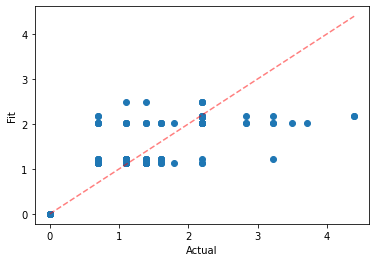

untransformed y
rmse 9.93
mae 3.54
mape 0.77


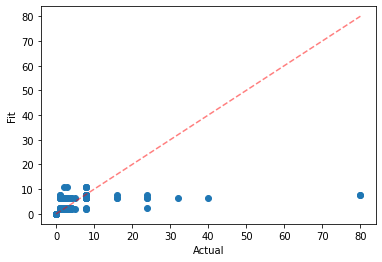

In [0]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"\ntrain_score: {train_score}")
print(f"test_score: {test_score}")

y_pred = pipeline_cv.predict(X_test)

print("transformed y")
eval_preds(y_test, y_pred)

print("untransformed y")
eval_preds(np.exp(y_test) - 1, np.exp(y_pred) - 1)

In [0]:
# Biggest issue is under predicting extremes
pred_df = pd.DataFrame(X_test).reset_index(drop=True)
pred_df["log_actual"] = y_test.values
pred_df["log_predicted"] = y_pred

pred_df["actual"] = np.exp(y_test.values) - 1
pred_df["predicted"] = np.exp(y_pred) - 1

pred_df["error"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_error"] = pred_df["error"].abs()

pred_df = pred_df.sort_values("abs_error", ascending=False)
pred_df.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,log_actual,log_predicted,actual,predicted,error,abs_error
101,13,7,2,1,369,17,12,264.604,93,0,1,3,1,0,0,70,169,4.394449,2.166424,80.0,7.727020,-72.272980,72.272980
114,13,6,4,3,118,13,18,377.550,94,0,1,1,1,0,0,98,178,4.394449,2.166424,80.0,7.727020,-72.272980,72.272980
87,11,3,2,2,179,22,17,343.253,95,0,2,2,0,1,0,63,170,3.713572,2.014757,40.0,6.498902,-33.501098,33.501098
79,14,9,2,4,291,31,12,241.476,92,0,1,1,1,0,1,73,171,3.496508,2.014757,32.0,6.498902,-25.501098,25.501098
62,28,6,2,3,179,51,18,253.957,95,0,1,0,1,0,0,89,170,3.218876,1.219128,24.0,2.384236,-21.615764,21.615764
